# Example Aggregation Zones

In spatial analysis and urban planning the division of objects into spatial zones is a pivotal tool to facilitate analysis and/or visualization. This jupyter notebook demonstrates how to create a **spatial joint** of the FIAT model data with single or multiple **aggregation zones** in order to link an the zone and objects of interest.   
The base for this notebook is the **DELFT FIAT toolbox**.  

*Note: The FIAT model was already initialized for this notebook. Unless the user does not wish to use own data, there is no need to create a new model and the user can simply continue with the example data found in the `/ "example" / "data"/ "aggregation_zone"` - directory.*

### Install Delft-FIAT

HydroMT-FIAT is available on pypi and can be installed via:  

`pip install hydromt_fiat`

If you want to know more about the installation process or if you are interested to install HydroMT-FIAT as a developer, please check out the [Installation Guide](../installation.rst).


# **Step 0**: Import required packages
Now we can import the neccessary python packages to build the **FIAT model**.

In [ ]:
# Import packages
import geopandas as gpd
from pathlib import Path
import os
from hydromt_fiat.fiat import FiatModel
from hydromt.log import setuplog
import pandas as pd
import yaml
import json
import shutil
from hydromt.config import configread

# **Before we start:** Study area and aggregation zones

<p>In this notebook we will spatially join three different aggregation zones to the <strong>FIAT exposure objects</strong>. 

The aggregation zones handled in this notebook are:
- **Base_zones**
- **Land_use**
- **Accommodation_type** 

The data was obtained from https://gis.charleston-sc.gov/

**Let's have a look at the study area and one of the aggregation zones that we would like to join!**

The map demonstrates the `Base_zones.gpkg` aggregation layer in Charelston, United States, which devides the county into base district zones. One of the three layers, that will be **spatially joined** with the objects in the `exposure data` (yellow markers) in this notebook. This can be achieved for multiple aggregation zone layers. 

In [ ]:
# Load aggregation zones as GeoDataFrames
exposure = gpd.read_file(
    Path(os.path.abspath(""))
    / "data"
    / "aggregation_zones"
    / "fiat_model"
    / "exposure"
    / "buildings.gpkg"
)
base_zone = gpd.read_file(
    Path(os.path.abspath(""))
    / "data"
    / "aggregation_zones"
    / "aggregation_zones"
    / "base_zones.gpkg"
)

# Create interactive map
m = base_zone.explore(column="ZONE_BASE")
m = exposure.explore(m=m, color="#FFFACD")

# Display map
m

# **Step 1**: Configure and initialize the FIAT model

In this notebook, the **FIAT model** has already been initialized and solely the exposure data will be updated by the add-on of the the aggregation zones. The required data is stored in the 
`"examples"/ "data" / "aggregation_zones / "aggregation_zones"` - directory.  

*Note: To configure and initialize your **own** FIAT model refer to  <a href="(https://github.com/Deltares/hydromt_fiat/blob/%2364FlexibleAggregationArea/examples/global_OSM_JRC.ipynb)"><em>global_OSM_JRC.ipynb</em></a>. If you do so, **don't forget** to update the folder dependencies and variables throughout this notebook pointing to your data.*  

# **Step 2**: Define aggregation parameters in the configuration file 

Two test cases are created in this jupyter notebook. For each test case we need a seperate configuration file ([configuration.yaml](data/aggregation_zones/configuration.yaml)/ [configuration_2.yaml](data/aggregation_zones/configuration_2.yaml)) with the required model input information:

1. Spatial joint of a **single aggregation zone** to the exposure data
2. Spatial joint of **multiple aggregation zones** to the exposure data

The configuration is saved in a *yaml* file, in which the following parameters must be specified by the user: 

- `aggregation_area_fn`: File path to the aggregation file (vector file). 
- `attribute_names`: Name of the column that specifies the aggregation zone in the aggregation vector file (case-sensitive).
- `label_names`: New aggregation label name, specified by the user.

Below an example of the input for the `attribute_names`. The column `"ZONE_BASE"`categorizes the aggregation zones in the vector file.

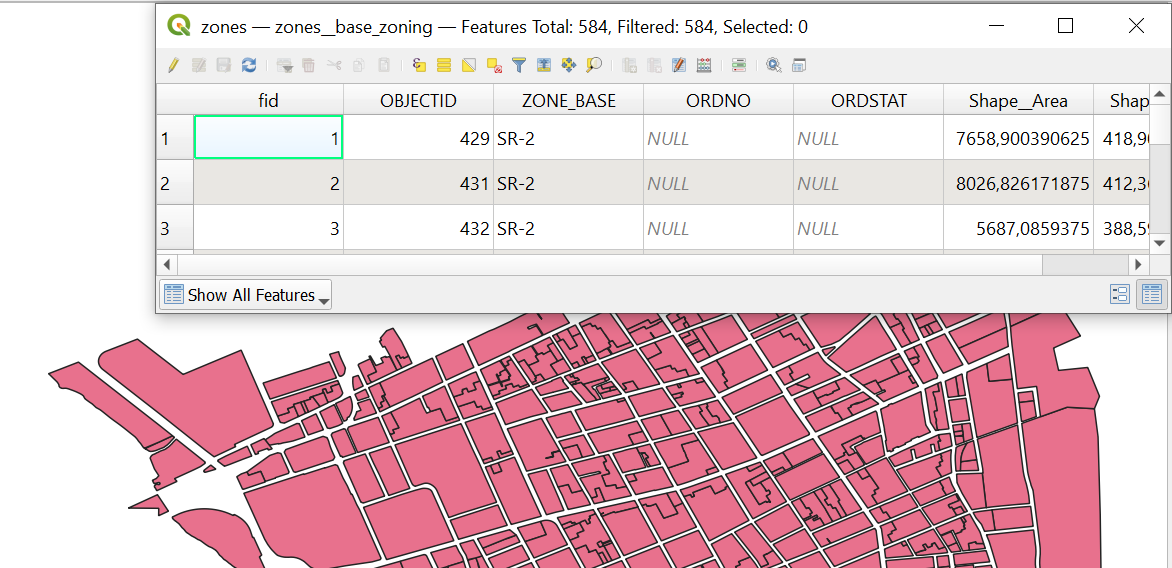

# **Step 3:** Load the configuration file

This step is not neccessarry to run the model. It is only for visualizing the model input. 
The configuration files are located in the `"example"/ "data" /` - folder. The information in the file are converted into a python dictionary.  

*Note: Instead of loading a yaml file it is possible to create a python dictionary directly, built upon the structure seen below.*

In [ ]:
# Let's read the yaml file with the required information

# Test Case 1
with open(
    Path(os.path.abspath("")) / "data" / "aggregation_zones" / "configuration.yaml", "r"
) as file:
    config_aggregation = yaml.safe_load(file)

print(f'"Test Case 1" {json.dumps(config_aggregation, indent=4, sort_keys=False)}')

# Test Case 2
with open(
    Path(os.path.abspath("")) / "data" / "aggregation_zones" / "configuration_2.yaml",
    "r",
) as file:
    config_aggregation_2 = yaml.safe_load(file)

print(f'"Test Case 2" {json.dumps(config_aggregation_2, indent=4, sort_keys=False)}')

# **Step 4**: <strong>Define variables for the FIAT model</strong>

Set up the root path to the FIAT model, the path where the output should be stored and the logger settings to re-build your model:

- `root`: Directory path from where the neccessary data for the FIAT model is stored. 
- `new_root`: Directory path where the FIAT model output is stored.  
- `logger`: The logger variable defines the frequencies of log-entries during the initialisation of the model.

In [ ]:
# Set up the root for the Fiat Model
root = Path(os.path.abspath("")) / "data" / "aggregation_zones" / "fiat_model"

# Set up the file path for the FIAT model output
new_root = (
    Path(os.path.abspath("")) / "data" / "aggregation_zones" / "aggregation_zones_test1"
)

# Set up the logger
logger = setuplog("hydromt_fiat", log_level=10)

# Read the model configuration
opt = configread(
    Path(os.path.abspath("")) / "data" / "aggregation_zones" / "configuration.yaml"
)

# **Test case 1**: Run the FIAT model

It's time to run the model with the new configuration of the aggregation zones. The output will be 
stored in the prior defined <em>`"new_root"`</em> - directory. The output will be a **new <em>exposure.csv</em>**, in which each object is assigned **spatially** to an **aggregation zone**. 

In [ ]:
# Read the existing FIAT model
fm = FiatModel(root=root, mode="r", logger=logger)
fm.read()

# If case exist
if new_root.exists():
    shutil.rmtree(new_root)

# Build the new model
fm.build(write=False, opt=opt)
fm.set_root(new_root)
fm.write()

# **Test case 2**: Run the FIAT model

To run the test case 2, select it the configuration dictionary when re-running the model. Hence, the model will select the parameters of the second test case instead of the first and create spatial joints to **multiple** aggregation zones. 

To run the second model, the `model variables` must be updated.

In [ ]:
# Set up the root for the Fiat Model
root = Path(os.path.abspath("")) / "data" / "aggregation_zones" / "fiat_model"

# Set up the file path for the FIAT model output
new_root = (
    Path(os.path.abspath("")) / "data" / "aggregation_zones" / "aggregation_zones_test2"
)

# Set up the logger
logger = setuplog("hydromt_fiat", log_level=10)

# Read the model configuration
opt = configread(
    Path(os.path.abspath("")) / "data" / "aggregation_zones" / "configuration_2.yaml"
)

In [ ]:
# Read the existing FIAT model
fm = FiatModel(root=root, mode="r", logger=logger)
fm.read()

# If case exist
if new_root.exists():
    shutil.rmtree(new_root)

# Build the new model
fm.build(write=False, opt=opt)
fm.set_root(new_root)
fm.write()

# **Done!**  
Your **FIAT model** created a **spatial joint** with your original objects and the aggregation zones. <p>Let's have a look at the output!</p>

# **Result**: Test Case 1

Load the newly created *exposure.csv* file from the <em>/ "output" / "aggregation_zones_test1" /</em> - directory and the original exposure geopackage from the <em> "exposure" / "buildings.gpkg" </em>. Before the results can be displayed, we must merge the **exposure.csv** with the  **buildings.gpkg** via common *"object_id"*. 

In [ ]:
# Load *.csv into dataframe
df_single_aggregation = pd.read_csv(
    Path(os.path.abspath(""))
    / "data"
    / "aggregation_zones"
    / "aggregation_zones_test1"
    / "exposure"
    / "exposure.csv"
)

# Load original exposure geopackage into GeoDataFrame
new_exposure = gpd.read_file(
    Path(os.path.abspath(""))
    / "data"
    / "aggregation_zones"
    / "aggregation_zones_test1"
    / "exposure"
    / "buildings.gpkg"
)

# Merge dataframe with GeoDataFrame
merged_gdf = new_exposure.merge(
    df_single_aggregation, left_on="object_id", right_on="object_id", how="inner"
)

# Display base_zones aggregation zone
base_zones_map = merged_gdf.explore(column="Base_zones")
base_zones_map

# **Result**: Test Case 2

Load the newly created *exposure.csv* file from the <em>/ "output" / "aggregation_zones_test2" /</em> - directory and the original exposure geopackage from the <em> "exposure" / "buildings.gpkg" </em>.  Before the results can be displayed, we must merge the **exposure.csv** with the  **buildings.gpkg** via common *"object_id"*. 

In [ ]:
# Load *.csv into dataframe
df_multiple_aggregation = pd.read_csv(
    Path(os.path.abspath(""))
    / "data"
    / "aggregation_zones"
    / "aggregation_zones_test2"
    / "exposure"
    / "exposure.csv"
)

# Load original exposure geopackage into GeoDataFrame
new_exposure = gpd.read_file(
    Path(os.path.abspath(""))
    / "data"
    / "aggregation_zones"
    / "aggregation_zones_test2"
    / "exposure"
    / "buildings.gpkg"
)

# Merge dataframe with GeoDataFrame
merged_gdf_multiple = new_exposure.merge(
    df_multiple_aggregation, left_on="object_id", right_on="object_id", how="inner"
)

### **Base Zones**

In [ ]:
# Display base_zones aggregation zone
base_zones_map = merged_gdf.explore(column="Base_zones")
base_zones_map

### **Land use**

In [ ]:
# Display land_use aggregation zone
land_use_map = merged_gdf_multiple.explore(column="Land_use")
land_use_map

### **Accomodation type**

In [ ]:
# Display accomodation_type aggregation zone
Accom_type_map = merged_gdf_multiple.explore(column="Accommodation_type")
Accom_type_map